1. Training Program (DeepLabV3plus and ResNet-101)

In [1]:
import os
import json
import math
import time
import random
from pathlib import Path
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
from PIL import Image, ImageDraw, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
Image.MAX_IMAGE_PIXELS = None

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
from torch.optim.lr_scheduler import LambdaLR
import segmentation_models_pytorch as smp

import seaborn as sns
import matplotlib.pyplot as plt


# ---------------- CONFIG ----------------
TRAIN_IMAGES = r"C:\Workspace\TEEP\ModelTraining\Program\Dataset\train\images"
TRAIN_LABELS = r"C:\Workspace\TEEP\ModelTraining\Program\Dataset\train\labels"
TEST_IMAGES  = r"C:\Workspace\TEEP\ModelTraining\Program\Dataset\test\images"
TEST_LABELS  = r"C:\Workspace\TEEP\ModelTraining\Program\Dataset\test\labels"

LABEL_NAME_TO_ID: Dict[str, int] = {
    "background": 0,
    "encrusting": 1,
    "softcoral":  2,
    "plate":      3,
    "massive":    4,
    "folios":     5,
    "branching":  6,
}
INTENDED_TOTAL_CLASSES = 7
IGNORE_INDEX = 255

NUM_EPOCHS   = 30
BATCH_SIZE   = 8
LR           = 1e-4
WEIGHT_DECAY = 1e-4
NUM_WORKERS  = 0
INPUT_SIZE   = (512, 512)
RANDOM_SEED  = 42


# ---------------- HELPERS ----------------
def _norm_label(s: str) -> str:
    return s.strip().lower().replace(" ", "").replace("-", "")

def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def find_image_label_pairs(images_dir: str, labels_dir: str):
    img_exts = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}
    images = [p for p in Path(images_dir).iterdir() if p.suffix.lower() in img_exts and p.is_file()]
    pairs = []
    for img in images:
        js = Path(labels_dir) / f"{img.stem}.json"
        if js.exists():
            pairs.append((img, js))
    return pairs

def labelme_json_to_mask(json_path: Path, size_wh, name2id, ignore_idx):
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    W, H = size_wh
    mask = Image.new("L", (W, H), color=0)
    draw = ImageDraw.Draw(mask)
    for shp in data.get("shapes", []):
        label = _norm_label(shp.get("label", ""))
        pts = shp.get("points", [])
        t = shp.get("shape_type", "polygon")
        cls_id = name2id.get(label, ignore_idx)
        poly = [tuple(pt) for pt in pts]
        if t == "rectangle" and len(poly) >= 2:
            (x1, y1), (x2, y2) = poly[0], poly[1]
            poly = [(x1, y1), (x2, y1), (x2, y2), (x1, y2)]
        if t in ("polygon", "rectangle") and len(poly) >= 3:
            draw.polygon(poly, fill=int(cls_id))
        elif t == "circle" and len(poly) >= 2:
            (cx, cy), (px, py) = poly[0], poly[1]
            r = math.hypot(px - cx, py - cy)
            draw.ellipse([cx - r, cy - r, cx + r, cy + r], fill=int(cls_id))
    return mask


class LabelMeSegmentation(Dataset):
    def __init__(self, pairs, name2id, input_size, augment=False, ignore_idx=255):
        self.pairs = pairs
        self.name2id = name2id
        self.input_size = input_size
        self.augment = augment
        self.ignore_idx = ignore_idx

    def __len__(self): return len(self.pairs)

    def _augment(self, img, mask):
        if random.random() < 0.5: img = TF.hflip(img); mask = TF.hflip(mask)
        if random.random() < 0.1: img = TF.vflip(img); mask = TF.vflip(mask)
        if random.random() < 0.2:
            k = random.choice([1, 2, 3])
            img = img.rotate(90 * k, resample=Image.BILINEAR)
            mask = mask.rotate(90 * k, resample=Image.NEAREST)
        return img, mask

    def __getitem__(self, idx):
        img_p, js_p = self.pairs[idx]
        img = Image.open(img_p).convert("RGB")
        W, H = img.size
        mask = labelme_json_to_mask(js_p, (W, H), self.name2id, self.ignore_idx)
        img = img.resize(self.input_size[::-1], Image.BILINEAR)
        mask = mask.resize(self.input_size[::-1], Image.NEAREST)
        if self.augment:
            img, mask = self._augment(img, mask)
        img = TF.normalize(TF.to_tensor(img),
                           mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
        mask = torch.from_numpy(np.array(mask)).long()
        return img, mask


@torch.no_grad()
def compute_confmat(pred, target, num_classes, ignore_idx):
    mask = target != ignore_idx
    valid_pred = pred[mask].view(-1)
    valid_tgt = target[mask].view(-1)
    cm = torch.zeros((num_classes, num_classes), dtype=torch.int64, device=pred.device)
    k = valid_tgt * num_classes + valid_pred
    bincount = torch.bincount(k, minlength=num_classes**2)
    cm += bincount.reshape(num_classes, num_classes)
    return cm.cpu().numpy()


@torch.no_grad()
def compute_metrics(pred, target, num_classes, ignore_idx):
    mask = target != ignore_idx
    if mask.sum() == 0: return 0.0, 0.0
    correct = (pred[mask] == target[mask]).sum().item()
    total = mask.sum().item()
    pixel_acc = correct / total
    cm = compute_confmat(pred, target, num_classes, ignore_idx)
    inter = np.diag(cm)
    union = cm.sum(1) + cm.sum(0) - inter
    miou = np.mean(inter / np.clip(union, 1, None))
    return pixel_acc, miou, cm


def main():
    set_seed(RANDOM_SEED)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_pairs = find_image_label_pairs(TRAIN_IMAGES, TRAIN_LABELS)
    test_pairs  = find_image_label_pairs(TEST_IMAGES, TEST_LABELS)
    random.shuffle(train_pairs); random.shuffle(test_pairs)

    train_ds = LabelMeSegmentation(train_pairs, LABEL_NAME_TO_ID, INPUT_SIZE, True, IGNORE_INDEX)
    test_ds  = LabelMeSegmentation(test_pairs, LABEL_NAME_TO_ID, INPUT_SIZE, False, IGNORE_INDEX)
    pin = device.type == "cuda"
    train_dl = DataLoader(train_ds, BATCH_SIZE, True,  num_workers=NUM_WORKERS, pin_memory=pin)
    test_dl  = DataLoader(test_ds,  BATCH_SIZE, False, num_workers=NUM_WORKERS, pin_memory=pin)

    model = smp.DeepLabV3Plus(
        encoder_name="resnet101",
        encoder_weights="imagenet",
        in_channels=3,
        classes=INTENDED_TOTAL_CLASSES
    ).to(device)

    crit = nn.CrossEntropyLoss(ignore_index=IGNORE_INDEX)
    opt = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

    warmup = 5
    def lr_lambda(ep):
        if ep < warmup: return (ep+1)/warmup
        p = (ep - warmup)/max(1, NUM_EPOCHS - warmup)
        return 0.1 + 0.9 * 0.5 * (1 + math.cos(math.pi*p))
    sched = LambdaLR(opt, lr_lambda=lr_lambda)
    scaler = torch.cuda.amp.GradScaler(enabled=device.type=="cuda")

    metrics_root = Path("Result/metrics")
    metrics_root.mkdir(parents=True, exist_ok=True)
    ckpt_path = metrics_root / "deeplabv3plus_resnet50_best.pt"
    best_miou = -1.0
    history = []

    for epoch in range(1, NUM_EPOCHS+1):
        model.train()
        total_loss = 0
        accs, mious = [], []
        for imgs, masks in train_dl:
            imgs, masks = imgs.to(device), masks.to(device)
            opt.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=device.type=="cuda"):
                out = model(imgs)
                loss = crit(out, masks)
            scaler.scale(loss).backward()
            scaler.step(opt); scaler.update()
            total_loss += loss.item()*imgs.size(0)
            preds = out.argmax(1)
            acc, miou, _ = compute_metrics(preds, masks, INTENDED_TOTAL_CLASSES, IGNORE_INDEX)
            accs.append(acc); mious.append(miou)
        sched.step()

        train_loss = total_loss/len(train_dl.dataset)
        train_acc = np.mean(accs); train_miou = np.mean(mious)
        print(f"Epoch {epoch:03d}: loss={train_loss:.4f} acc={train_acc:.4f} mIoU={train_miou:.4f}")

        # validation & confusion matrix
        model.eval()
        all_cm = np.zeros((INTENDED_TOTAL_CLASSES, INTENDED_TOTAL_CLASSES), dtype=np.int64)
        val_accs, val_mious = [], []
        for imgs, masks in test_dl:
            imgs, masks = imgs.to(device), masks.to(device)
            with torch.cuda.amp.autocast(enabled=device.type=="cuda"):
                out = model(imgs)
            preds = out.argmax(1)
            acc, miou, cm = compute_metrics(preds, masks, INTENDED_TOTAL_CLASSES, IGNORE_INDEX)
            val_accs.append(acc); val_mious.append(miou)
            all_cm += cm

        val_acc, val_miou = np.mean(val_accs), np.mean(val_mious)
        history.append({"epoch": epoch, "train_loss": train_loss,
                        "train_acc": train_acc, "train_miou": train_miou,
                        "val_acc": val_acc, "val_miou": val_miou})

        # save best
        if val_miou > best_miou:
            best_miou = val_miou
            torch.save(model.state_dict(), ckpt_path)
            print(f"[INFO] saved best model (mIoU={best_miou:.4f})")

        # ---- save confusion matrix + excel ----
        epoch_dir = metrics_root / f"epoch_{epoch:02d}"
        epoch_dir.mkdir(exist_ok=True)
        cm_df = pd.DataFrame(all_cm,
                             index=[f"True_{i}" for i in range(INTENDED_TOTAL_CLASSES)],
                             columns=[f"Pred_{i}" for i in range(INTENDED_TOTAL_CLASSES)])
        metrics_df = pd.DataFrame(history)
        excel_path = epoch_dir / "training_metrics.xlsx"
        with pd.ExcelWriter(excel_path) as writer:
            metrics_df.to_excel(writer, sheet_name="Metrics", index=False)
            cm_df.to_excel(writer, sheet_name=f"ConfusionMatrix_Epoch{epoch}", index=True)

        plt.figure(figsize=(8,6))
        sns.heatmap(all_cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=[f"Pred_{i}" for i in range(INTENDED_TOTAL_CLASSES)],
                    yticklabels=[f"True_{i}" for i in range(INTENDED_TOTAL_CLASSES)])
        plt.xlabel("Predicted Class")
        plt.ylabel("True Class")
        plt.title(f"Confusion Matrix Epoch {epoch}")
        plt.tight_layout()
        plt.savefig(epoch_dir / f"confusion_matrix_epoch{epoch}.png")
        plt.close()

    print(f"[DONE] Best model saved at {ckpt_path}")


if __name__ == "__main__":
    main()

c:\Users\marce\anaconda3\envs\MEST\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:189: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=device.type=="cuda")
C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:204: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


Epoch 001: loss=1.5418 acc=0.5874 mIoU=0.1432


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:225: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


[INFO] saved best model (mIoU=0.2275)


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:204: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


Epoch 002: loss=1.0131 acc=0.8701 mIoU=0.2511


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:225: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


[INFO] saved best model (mIoU=0.2727)


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:204: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


Epoch 003: loss=0.6588 acc=0.9072 mIoU=0.2834


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:225: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


[INFO] saved best model (mIoU=0.2898)


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:204: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


Epoch 004: loss=0.4716 acc=0.9186 mIoU=0.3221


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:225: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


[INFO] saved best model (mIoU=0.3166)


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:204: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


Epoch 005: loss=0.3973 acc=0.9190 mIoU=0.3340


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:225: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


[INFO] saved best model (mIoU=0.3600)


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:204: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


Epoch 006: loss=0.2997 acc=0.9343 mIoU=0.3751


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:225: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


[INFO] saved best model (mIoU=0.3609)


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:204: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


Epoch 007: loss=0.2296 acc=0.9471 mIoU=0.4137


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:225: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


[INFO] saved best model (mIoU=0.4077)


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:204: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


Epoch 008: loss=0.2143 acc=0.9469 mIoU=0.4149


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:225: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):
C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:204: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


Epoch 009: loss=0.1801 acc=0.9543 mIoU=0.4464


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:225: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):
C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:204: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


Epoch 010: loss=0.1491 acc=0.9627 mIoU=0.4650


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:225: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


[INFO] saved best model (mIoU=0.4245)


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:204: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


Epoch 011: loss=0.1280 acc=0.9679 mIoU=0.4858


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:225: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


[INFO] saved best model (mIoU=0.4471)


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:204: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


Epoch 012: loss=0.1314 acc=0.9649 mIoU=0.4894


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:225: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):
C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:204: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


Epoch 013: loss=0.1154 acc=0.9692 mIoU=0.5016


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:225: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


[INFO] saved best model (mIoU=0.4586)


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:204: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


Epoch 014: loss=0.1039 acc=0.9715 mIoU=0.5047


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:225: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


[INFO] saved best model (mIoU=0.4684)


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:204: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


Epoch 015: loss=0.0907 acc=0.9753 mIoU=0.5213


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:225: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


[INFO] saved best model (mIoU=0.4695)


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:204: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


Epoch 016: loss=0.0959 acc=0.9725 mIoU=0.5161


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:225: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


[INFO] saved best model (mIoU=0.4750)


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:204: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


Epoch 017: loss=0.0858 acc=0.9767 mIoU=0.5249


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:225: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):
C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:204: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


Epoch 018: loss=0.0770 acc=0.9788 mIoU=0.5452


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:225: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


[INFO] saved best model (mIoU=0.4809)


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:204: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


Epoch 019: loss=0.0683 acc=0.9807 mIoU=0.5382


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:225: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):
C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:204: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


Epoch 020: loss=0.0671 acc=0.9809 mIoU=0.5420


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:225: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


[INFO] saved best model (mIoU=0.4849)


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:204: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


Epoch 021: loss=0.0657 acc=0.9810 mIoU=0.5495


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:225: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):
C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:204: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


Epoch 022: loss=0.0599 acc=0.9829 mIoU=0.5493


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:225: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):
C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:204: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


Epoch 023: loss=0.0544 acc=0.9843 mIoU=0.5455


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:225: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


[INFO] saved best model (mIoU=0.4892)


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:204: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


Epoch 024: loss=0.0564 acc=0.9830 mIoU=0.5460


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:225: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):
C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:204: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


Epoch 025: loss=0.0565 acc=0.9836 mIoU=0.5545


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:225: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):
C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:204: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


Epoch 026: loss=0.0549 acc=0.9838 mIoU=0.5557


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:225: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):
C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:204: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


Epoch 027: loss=0.0517 acc=0.9849 mIoU=0.5540


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:225: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):
C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:204: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


Epoch 028: loss=0.0502 acc=0.9853 mIoU=0.5502


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:225: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):
C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:204: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


Epoch 029: loss=0.0471 acc=0.9862 mIoU=0.5676


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:225: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):
C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:204: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


Epoch 030: loss=0.0472 acc=0.9860 mIoU=0.5682


C:\Users\marce\AppData\Local\Temp\ipykernel_1508\2922726538.py:225: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type=="cuda"):


[INFO] saved best model (mIoU=0.4895)
[DONE] Best model saved at Result\metrics\deeplabv3plus_resnet50_best.pt


2. Coral Recognition

In [ ]:
import os
from pathlib import Path
import math
import tempfile
import numpy as np
from PIL import Image, ImageOps, ImageFile

Image.MAX_IMAGE_PIXELS = None
ImageFile.LOAD_TRUNCATED_IMAGES = True

import torch
import torch.nn.functional as F
import torchvision.transforms as T
from torch.cuda.amp import autocast
import segmentation_models_pytorch as smp

ORTHO_PATH   = r"C:\Workspace\TEEP\ModelTraining\Program\Test\Ortho.png"
MODEL_PATH   = r"C:\Workspace\TEEP\ModelTraining\Program\Model\deeplabv3plus_resnet101.pt"
OUT_MASK     = r"C:\Workspace\TEEP\ModelTraining\Program\Result\mask.png"
OUT_OVERLAY  = r"C:\Workspace\TEEP\ModelTraining\Program\Result\overlay.png"

NUM_CLASSES = 7
CLASS_TO_ID = {
    "background":0, "encrusting":1, "softcoral":2,
    "plate":3, "massive":4, "folios":5, "branching":6
}
ID_TO_COLOR = np.array([
    [0,0,0],        # background
    [220,20,60],    # encrusting
    [0,128,0],      # softcoral
    [70,130,180],   # plate
    [255,165,0],    # massive
    [138,43,226],   # folios
    [255,255,0],    # branching
], dtype=np.uint8)

TILE    = 768      
OVERLAP = 128       
BATCH   = 4

USE_CLAHE     = False
USE_GRAYWORLD = False
USE_TTA       = True

MAX_LONG_SIDE = 6000
SCALES        = [1.0] 
ADAPTIVE_TILE = True
USE_AMP       = True

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]
to_tensor = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

def pil_to_np(img):
    return np.asarray(img)

def np_to_pil(x):
    return Image.fromarray(x)

def clahe_rgb(img_pil):
    try:
        import cv2
    except ImportError:
        return img_pil
    img = np.array(img_pil.convert("RGB"))
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    l2 = clahe.apply(l)
    lab2 = cv2.merge([l2,a,b])
    rgb = cv2.cvtColor(lab2, cv2.COLOR_LAB2RGB)
    return Image.fromarray(rgb)

def grayworld_balance(img_pil):
    img = np.asarray(img_pil).astype(np.float32)
    means = img.reshape(-1,3).mean(axis=0) + 1e-6
    gain = means.mean() / means
    out = np.clip(img * gain, 0, 255).astype(np.uint8)
    return Image.fromarray(out)

def preprocess_pil(img_pil):
    if USE_CLAHE:
        img_pil = clahe_rgb(img_pil)
    if USE_GRAYWORLD:
        img_pil = grayworld_balance(img_pil)
    return img_pil

def tta_tiles(batch):
    outs = []
    x = batch
    outs.append((x, lambda y: y))
    if USE_TTA:
        x1 = torch.flip(x, dims=[-1])
        outs.append((x1, lambda y: torch.flip(y, dims=[-1])))
        x2 = torch.flip(x, dims=[-2])
        outs.append((x2, lambda y: torch.flip(y, dims=[-2])))
        x3 = torch.flip(x, dims=[-1, -2])
        outs.append((x3, lambda y: torch.flip(y, dims=[-1, -2])))
    return outs

def colorize(mask):
    return ID_TO_COLOR[mask]

def resize_pil(img, scale):
    if scale == 1.0:
        return img, 1.0
    w, h = img.size
    nw, nh = int(round(w*scale)), int(round(h*scale))
    return img.resize((nw, nh), Image.BILINEAR), scale

def choose_tile_and_batch():
    global TILE, BATCH
    if not ADAPTIVE_TILE or DEVICE != "cuda":
        return TILE, BATCH
    try:
        torch.cuda.synchronize(); torch.cuda.empty_cache()
        free = torch.cuda.mem_get_info()[0] / (1024**3) 
    except Exception:
        return TILE, BATCH
    if free > 10: return 1024, 8
    if free > 6:  return 896, 4
    if free > 4:  return 768, 2
    return 640, 1

def load_model():
    model = smp.DeepLabV3Plus(
        encoder_name="resnet101",
        encoder_weights=None,
        in_channels=3,
        classes=NUM_CLASSES
    )
    ckpt = torch.load(MODEL_PATH, map_location="cpu")

    if "model_state" in ckpt:
        state = ckpt["model_state"]
    elif "state_dict" in ckpt:
        state = ckpt["state_dict"]
    else:
        state = ckpt

    clean = {}
    for k, v in state.items():
        k2 = k.replace("module.", "").replace("model.", "")
        clean[k2] = v

    model_keys = set(model.state_dict().keys())
    filtered = {k: v for k, v in clean.items() if k in model_keys}
    print(f"Checkpoint params: {len(clean)} | Matched with model: {len(filtered)}")

    model.load_state_dict(filtered, strict=False)
    model = model.to(DEVICE).eval()
    if DEVICE == "cuda":
        model = model.to(memory_format=torch.channels_last)
    return model

def predict_batch(model, batch):
    preds = []
    with autocast(enabled=(USE_AMP and DEVICE == "cuda")):
        for xb, invert in tta_tiles(batch.to(memory_format=torch.channels_last)):
            logits = model(xb)               # [B, C, T, T]
            logits = invert(logits)
            probs = F.softmax(logits, dim=1)
            preds.append(probs)
    return torch.stack(preds, dim=0).mean(dim=0)  # mean probabilities

def place_cpu(acc_mm, cnt_mm, probs, coords, win):
    probs_cpu = probs.detach().to("cpu").numpy()   
    win_cpu   = win.detach().to("cpu").numpy()      
    B, C, T_, _ = probs_cpu.shape
    for i, (x, y) in enumerate(coords):
        acc_mm[:, y:y+T_, x:x+T_] += probs_cpu[i] * win_cpu[None, ...]
        cnt_mm[:, y:y+T_, x:x+T_] += win_cpu[None, ...]

def infer_large_memmap(model, img_pil, tmp_dir, tile, overlap, batch):
    W, H = img_pil.size
    # compute padded size so strides land on edges
    pad_right  = (math.ceil(max(W - tile, 0) / (tile - overlap))*(tile-overlap) + tile) - W if W > tile else tile - W
    pad_bottom = (math.ceil(max(H - tile, 0) / (tile - overlap))*(tile-overlap) + tile) - H if H > tile else tile - H
    pad_w, pad_h = max(0, pad_right), max(0, pad_bottom)
    img_pad = ImageOps.expand(img_pil, border=(0,0,pad_w,pad_h), fill=0)
    WP, HP = img_pad.size

    xs = list(range(0, max(WP - tile, 0) + 1, tile - overlap))
    ys = list(range(0, max(HP - tile, 0) + 1, tile - overlap))

    acc_path = os.path.join(tmp_dir, "acc.dat")
    cnt_path = os.path.join(tmp_dir, "cnt.dat")
    acc = np.memmap(acc_path, mode="w+", dtype=np.float32, shape=(NUM_CLASSES, HP, WP))
    cnt = np.memmap(cnt_path, mode="w+", dtype=np.float32, shape=(1, HP, WP))
    acc[:] = 0.0
    cnt[:] = 0.0

    w = torch.hann_window(tile, periodic=False, device=DEVICE)
    win = (w[:, None] * w[None, :]).clamp_min(1e-3)

    tiles, coords = [], []
    for y in ys:
        for x in xs:
            crop = img_pad.crop((x, y, x+tile, y+tile))
            tiles.append(to_tensor(crop))
            coords.append((x, y))
            if len(tiles) == batch:
                with torch.no_grad():
                    batch_t = torch.stack(tiles, dim=0).to(DEVICE)
                    probs = predict_batch(model, batch_t)
                    place_cpu(acc, cnt, probs, coords, win)
                tiles, coords = [], []
    if tiles:
        with torch.no_grad():
            batch_t = torch.stack(tiles, dim=0).to(DEVICE)
            probs = predict_batch(model, batch_t)
            place_cpu(acc, cnt, probs, coords, win)

    cnt = np.maximum(cnt[:, :H, :W], 1e-6)
    acc = acc[:, :H, :W] / cnt
    pred = np.argmax(acc, axis=0).astype(np.uint8)

    del acc, cnt
    return pred

def infer_scaled(model, img_pil, tmp_dir, scales):
    W0, H0 = img_pil.size
    long_side = max(W0, H0)
    auto_scale = 1.0
    if long_side > MAX_LONG_SIDE:
        auto_scale = MAX_LONG_SIDE / float(long_side)

    votes = []
    for s in scales:
        s_eff = s * auto_scale
        img_s, _ = resize_pil(img_pil, s_eff)

        tile_cur, batch_cur = choose_tile_and_batch()

        mask_s = infer_large_memmap(
            model, img_s, tmp_dir,
            tile=tile_cur, overlap=OVERLAP, batch=batch_cur
        )
        mask_up = np.array(Image.fromarray(mask_s, mode="L").resize((W0, H0), Image.NEAREST))
        votes.append(mask_up)

    if len(votes) == 1:
        return votes[0]

    votes = np.stack(votes, axis=-1)
    H, W, K = votes.shape
    out = np.zeros((H, W), dtype=np.uint8)
    for c in range(NUM_CLASSES):
        count_c = (votes == c).sum(axis=-1)
        out = np.where(count_c > (K // 2), c, out)
    return out

def save_overlay_tiled(base_img_pil, mask_uint8, out_path, tile=1024, alpha_num=2, alpha_den=5):
    assert base_img_pil.mode == "RGB"
    W, H = base_img_pil.size
    out = Image.new("RGB", (W, H))

    a, b, den = alpha_num, alpha_den - alpha_num, alpha_den

    for y0 in range(0, H, tile):
        for x0 in range(0, W, tile):
            x1, y1 = min(x0 + tile, W), min(y0 + tile, H)
            base_tile = np.asarray(base_img_pil.crop((x0, y0, x1, y1)), dtype=np.uint8)
            mask_tile = mask_uint8[y0:y1, x0:x1]
            color_tile = ID_TO_COLOR[mask_tile]   
            mix = ((b * base_tile.astype(np.uint16) +
                    a * color_tile.astype(np.uint16) +
                    den // 2) // den).astype(np.uint8)
            out.paste(Image.fromarray(mix, mode="RGB"), (x0, y0))
    out.save(out_path)

def main():
    os.makedirs(Path(OUT_MASK).parent, exist_ok=True)

    img = Image.open(ORTHO_PATH).convert("RGB")
    img = preprocess_pil(img)

    model = load_model()

    with tempfile.TemporaryDirectory(prefix="reef_tiled_") as tmpdir:
        mask = infer_scaled(model, img, tmpdir, scales=SCALES)

    Image.fromarray(mask).save(OUT_MASK)

    save_overlay_tiled(img, mask, OUT_OVERLAY, tile=1024, alpha_num=2, alpha_den=5)

    unique, counts = np.unique(mask, return_counts=True)
    print("Class histogram:", dict(zip(unique.tolist(), counts.tolist())))
    print(f"Saved:\n  {OUT_MASK}\n  {OUT_OVERLAY}")

if __name__ == "__main__":
    main()

c:\Users\marce\anaconda3\envs\MEST\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Checkpoint params: 685 | Matched with model: 685


C:\Users\marce\AppData\Local\Temp\ipykernel_20160\3241017108.py:163: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(USE_AMP and DEVICE == "cuda")):
C:\Users\marce\AppData\Local\Temp\ipykernel_20160\3241017108.py:244: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  mask_up = np.array(Image.fromarray(mask_s, mode="L").resize((W0, H0), Image.NEAREST))
C:\Users\marce\AppData\Local\Temp\ipykernel_20160\3241017108.py:274: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  out.paste(Image.fromarray(mix, mode="RGB"), (x0, y0))


Class histogram: {0: 290443452, 1: 40956017, 3: 9423483, 4: 3061656, 5: 629383, 6: 377669}
Saved:
  C:\Workspace\TEEP\ModelTraining\Program\Result\mask.png
  C:\Workspace\TEEP\ModelTraining\Program\Result\overlay.png


3. Coverage Calculation

Wrote C:\Workspace\TEEP\ModelTraining\Program\Result\coverage.csv
Total pixels : 344891660
Total area   : 46.453113 m^2
Wrote C:\Workspace\TEEP\ModelTraining\Program\Result\coverage.png


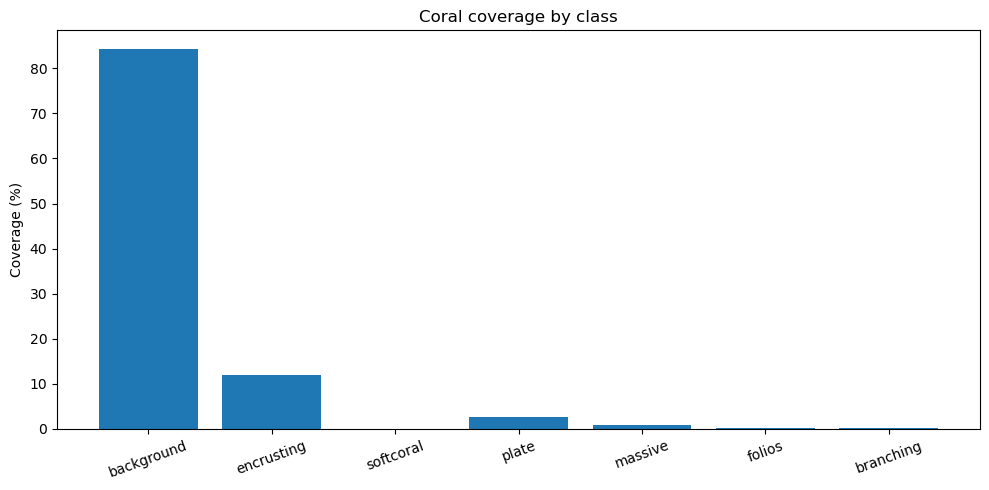

In [2]:
import csv
from pathlib import Path
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

MASK_PATH = r"C:\Workspace\TEEP\ModelTraining\Program\Result\mask.png"
CSV_PATH  = r"C:\Workspace\TEEP\ModelTraining\Program\Result\coverage.csv"
PLOT_PATH = r"C:\Workspace\TEEP\ModelTraining\Program\Result\coverage.png"

PIXEL_SIZE_M = 0.000367 

CLASS_NAMES = ["background","encrusting","softcoral","plate","massive","folios","branching"]

def main():
    # Load mask
    mask = np.array(Image.open(MASK_PATH))

    # Total pixel dalam gambar
    total_px = mask.size

    # Hitung piksel per kelas
    counts = [(mask == i).sum() for i in range(len(CLASS_NAMES))]

    # Luas per kelas
    areas_m2 = [c * (PIXEL_SIZE_M**2) for c in counts]

    # Total area seluruh gambar
    total_area_m2 = total_px * (PIXEL_SIZE_M**2)

    # Persentase area per kelas
    percents = [100.0 * a / total_area_m2 if total_area_m2 > 0 else 0 for a in areas_m2]

    # Tulis ke CSV
    Path(CSV_PATH).parent.mkdir(parents=True, exist_ok=True)
    with open(CSV_PATH, "w", newline="") as f:
        w = csv.writer(f)
        w.writerow(["class", "pixels", "area_m2", "percent"])

        for cls, px, am2, p in zip(CLASS_NAMES, counts, areas_m2, percents):
            w.writerow([cls, int(px), f"{am2:.6f}", f"{p:.3f}"])

        # Tambahkan baris TOTAL
        w.writerow([])
        w.writerow(["TOTAL", int(total_px), f"{total_area_m2:.6f}", "100.000"])

    print(f"Wrote {CSV_PATH}")
    print(f"Total pixels : {total_px}")
    print(f"Total area   : {total_area_m2:.6f} m^2")

    # Plot bar chart
    plt.figure(figsize=(10,5))
    x = np.arange(len(CLASS_NAMES))
    plt.bar(x, percents)
    plt.xticks(x, CLASS_NAMES, rotation=20)
    plt.ylabel("Coverage (%)")
    plt.title("Coral coverage by class")
    plt.tight_layout()
    plt.savefig(PLOT_PATH, dpi=200)

    print(f"Wrote {PLOT_PATH}")

if __name__ == "__main__":
    main()
